# Using processed_Files from Mt_construction_attemp1 for Clustering After Treating Intensity Data

In [28]:
import pickle
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn import metrics
from sklearn.cluster import KMeans
from scipy.stats import pearsonr
from  scipy.spatial.distance import pdist, squareform
import multiprocessing as mp


In [29]:
!pwd
import os
os.chdir('./fixMT/notebook/')
!pwd

/pod/2/activities/jaxcc/CATch-project/analysis/tkhan/fixMT/notebook


FileNotFoundError: [Errno 2] No such file or directory: './fixMT/notebook/'

# read data from checkpoint

In [31]:
with open('../ckpnt/processed_files_nonNormalized.pkl', 'rb') as file:
    processed_files = pickle.load(file)
print (processed_files.keys())

dict_keys(['Kawasaki', 'TB', 'RSV', 'SLE', 'B_Cell_Deficiency', 'Flu', 'Liver_Transplant', 'Juvenile_Dermatomyositis', 'Sepsis', 'Melanoma', 'HIV', 'Pregnancy', 'MS', 'Staph', 'SoJIA', 'COPD'])


<Axes: >

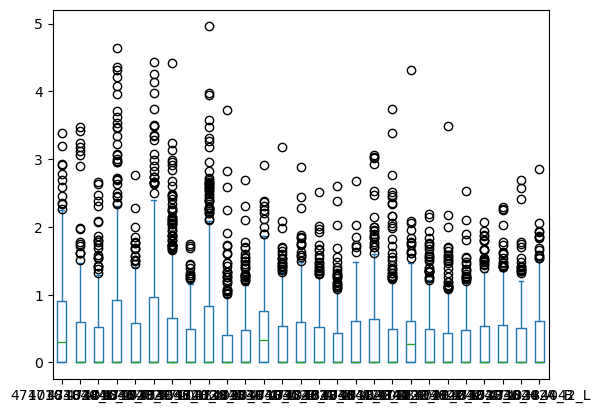

In [32]:
processed_files['Melanoma'].plot(kind='box')

# Read BG3 file for sanity check

In [5]:
il12 = pd.read_csv("../data/mappingFiles/HumanHT-12_V3_0_R3_11283641_A.txt",sep="\t",skiprows=8)
probeDict_map = il12[['Probe_Id','ILMN_Gene']].dropna().set_index('Probe_Id').to_dict()['ILMN_Gene']

bg3_pub = pd.read_excel("../data/pubdata/41467_2021_24584_MOESM4_ESM.xlsx",sheet_name="Supplementary_Table_vDEC2019")
bg3_pubDF = []#pd.DataFrame(columns=['ID','Genes','Probes'])
for k in bg3_pub.index:
    m_name = bg3_pub.loc[k,'ID']
    genes = bg3_pub.loc[k,'Member genes'].split(",")
    probes = bg3_pub.loc[k,'Module Probe IDs'].split(",")
    for p,g in zip(probes,genes):
        bg3_pubDF.append([m_name,g,p,bg3_pub.loc[k,'Module title']])
bg3_pubDF = pd.DataFrame(bg3_pubDF,columns=['ID','Genes','Probes','modtitle'])
bg3_pubDF['Probes'] = bg3_pubDF['Probes'].str.strip()
bg3_pubDF['Genes'] = bg3_pubDF['Genes'].str.strip()
bg3_pubDF['ID'] = bg3_pubDF['ID'].str.strip()


bg3_pubDF['outerloop'] = bg3_pubDF['ID'].str.split(".").str[0].str[1:]
bg3_pubDF['innerloop'] = bg3_pubDF['ID'].str.split(".").str[1]
bg3_pubDF['outerloop'] = bg3_pubDF['outerloop'].astype(int)
bg3_pubDF['innerloop'] = bg3_pubDF['innerloop'].astype(int)

bg3_pubDF.sort_values(by=['outerloop','innerloop'],inplace=True)
bg3_pubDF[bg3_pubDF.ID=="M3.1"]

,ID,Genes,Probes,modtitle,outerloop,innerloop
0,M3.1,ALPP,1693789,Cell cycle,3,1
1,M3.1,ALS2CR14,1787314,Cell cycle,3,1
2,M3.1,ANKRD30B,1730678,Cell cycle,3,1
3,M3.1,ARL16,2188119,Cell cycle,3,1
4,M3.1,BCYRN1,1678757,Cell cycle,3,1
...,...,...,...,...,...,...
104,M3.1,ZNF652,2155322,Cell cycle,3,1
105,M3.1,ZNF669,2093748,Cell cycle,3,1
106,M3.1,ZNF682,2313889,Cell cycle,3,1
107,M3.1,ZNF69,2176882,Cell cycle,3,1


# check the probe presence in dataset
probes from gene module 3.1 should be present in at-least 14 datasets

In [33]:
# for each data set get the probe density i.e. number of samples the probe is present in
probe_density = pd.DataFrame(columns=processed_files.keys())
for k in processed_files.keys():
    tmpx = processed_files[k][processed_files[k]>0].fillna(0).astype(bool).sum(axis=1)/processed_files[k].shape[0]
    print (tmpx.shape)
    probe_density = probe_density.reindex(probe_density.index.union(tmpx.index))
    probe_density[k] = tmpx

(4949,)
(2625,)
(7131,)
(9138,)
(2359,)
(2568,)
(9581,)
(4128,)
(7098,)
(552,)
(7809,)
(4054,)
(6449,)
(9308,)
(8847,)
(4603,)


In [34]:
probe_densityx = probe_density.fillna(0).astype(bool).sum(axis=1).sort_values(ascending=False).to_frame().rename(columns={0:'n_samples'})
# rename index by replacing indexname wtih stripped ILMN_
probe_densityx.index = probe_densityx.index.str.replace("ILMN_","")
probe_densityx.head()

,n_samples
1796755,16
1762957,16
1674265,16
1776333,16
2190842,16


In [35]:
m3_1 = bg3_pubDF[bg3_pubDF.ID=="M3.1"].set_index('Probes').join(probe_densityx, how='left')
m3_1.sort_values(by='n_samples',ascending=False)

,ID,Genes,modtitle,outerloop,innerloop,n_samples
Probes,,,,,,
2061419,M3.1,CYCSL1,Cell cycle,3,1,11.0
2082893,M3.1,LOC440157,Cell cycle,3,1,11.0
1916457,M3.1,HS.576072,Cell cycle,3,1,9.0
2246548,M3.1,GSTTP2,Cell cycle,3,1,9.0
1746919,M3.1,LOC643882,Cell cycle,3,1,9.0
...,...,...,...,...,...,...
2212823,M3.1,ZNF577,Cell cycle,3,1,NaN
2155322,M3.1,ZNF652,Cell cycle,3,1,NaN
2313889,M3.1,ZNF682,Cell cycle,3,1,NaN


In [37]:
m3_1.dropna()

,ID,Genes,modtitle,outerloop,innerloop,n_samples
Probes,,,,,,
1787314,M3.1,ALS2CR14,Cell cycle,3,1,4.0
2106656,M3.1,BLZF1,Cell cycle,3,1,1.0
2243516,M3.1,C11ORF63,Cell cycle,3,1,6.0
2228196,M3.1,C6ORF170,Cell cycle,3,1,1.0
1738678,M3.1,C9ORF130,Cell cycle,3,1,4.0
2061419,M3.1,CYCSL1,Cell cycle,3,1,11.0
2161286,M3.1,FAM40B,Cell cycle,3,1,1.0
1771320,M3.1,FLJ38717,Cell cycle,3,1,4.0
1671039,M3.1,GALNT3,Cell cycle,3,1,2.0


In [14]:
def rank_normalize_scaled(df):
    """
    Perform rank normalization for a Pandas DataFrame (row-wise) and scale ranks between 0 and 1.
    
    Parameters:
    - df: Pandas DataFrame where rows represent samples and columns represent gene expression values.
    
    Returns:
    - rank_normalized_df: A DataFrame with rank-normalized values between 0 and 1.
    """
    # Apply rank normalization row-wise, replacing values with their ranks
    ranked_df = df.apply(lambda x: x.rank(method='average'), axis=1)
    
    # Scale the ranks to the range [0, 1]
    rank_normalized_df = ranked_df.apply(lambda x: (x - 1) / (len(x) - 1), axis=1)
    
    return rank_normalized_df

In [11]:
tx = processed_files['Melanoma'].T
tx.head()

ID_REF,ILMN_1729115,ILMN_2349129,ILMN_1750876,ILMN_1715508,ILMN_1726698,ILMN_1668639,ILMN_1728331,ILMN_1703683,ILMN_2346649,ILMN_1655684,...,ILMN_1815908,ILMN_1779706,ILMN_1781638,ILMN_2072541,ILMN_1737514,ILMN_1709877,ILMN_1829845,ILMN_1761442,ILMN_1675266,ILMN_1741334
4710384024_L,0.0,0.0,0.411471,0.484115,1.048690,0.431781,1.182817,0.706853,0.265571,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.980434,0.421566,0.0,0.0,0.000000
4710384046_D,0.0,0.0,0.000000,0.000000,0.000000,0.663949,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.915102,0.0,0.0,0.000000
4710384046_F,0.0,0.0,0.000000,0.000000,0.348299,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.326259,0.000000,0.000000,0.0,0.0,0.000000
4710384028_F,0.0,0.0,0.000000,0.489734,0.000000,0.422577,0.445006,0.000000,0.000000,0.0,...,0.877811,0.0,0.0,0.000000,0.000000,1.757236,0.000000,0.0,0.0,0.718004
4710384028_G,0.0,0.0,0.000000,0.000000,0.382849,0.000000,0.268605,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.606398,0.000000,0.000000,0.000000,0.0,0.0,0.577660


<Axes: ylabel='Frequency'>

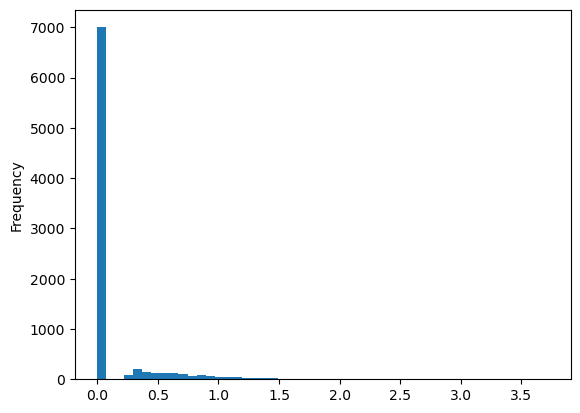

In [32]:
tx.loc['4710384024_L'].plot(kind="hist", bins=50)

In [15]:
tx_norm = rank_normalize_scaled(tx)  # Perform rank normalization

<Axes: ylabel='Frequency'>

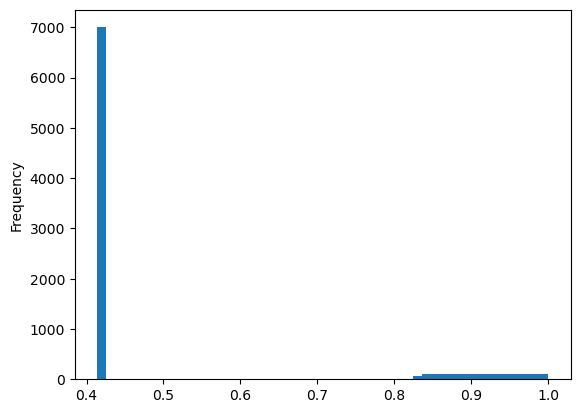

In [33]:
tx_norm.loc['4710384024_L'].plot(kind="hist", bins=50)

In [35]:
from tqdm import tqdm

def hartigan_kmeans_with_optimal_range(data, correlation_threshold=0.3, k_min=2, k_max=30):
    """
    Perform Hartigan's K-Means within a selected range of k.
    Use Pearson correlation check to validate clusters.
    
    Parameters:
    - data: np.ndarray, rows are probes and columns are samples.
    - correlation_threshold: float, threshold for Pearson correlation.
    - k_min: int, minimum number of clusters to test.
    - k_max: int, maximum number of clusters to test.
    
    Returns:
    - labels: np.ndarray, final cluster labels.
    - best_k: int, the number of clusters that passed the Pearson correlation check.
    """
    
    # Apply Hartigan's K-Means starting from optimal_k
    for k in range(k_max, k_min - 1, -1):
        print(f"Clustering with k = {k} clusters...")
        
        kmeans = KMeans(n_clusters=k, random_state=42,max_iter=100,init='k-means++')
        labels = kmeans.fit_predict(data)
        centroids = kmeans.cluster_centers_
        
        is_valid_k = True
        for cluster in range(k):
            cluster_indices = np.where(labels == cluster)[0]
            cluster_data = data[cluster_indices]
            
            mean_vector = centroids[cluster]
            correlations = [pearsonr(probe, mean_vector)[0] for probe in cluster_data]
            avg_correlation = np.mean(correlations)
            
            if avg_correlation < correlation_threshold:
                print(f"Cluster {cluster} rejected at k={k} due to low average correlation ({avg_correlation:.2f}).")
                is_valid_k = False
                break  # Restart with k-1
        
        if is_valid_k:
            print(f"Valid clustering found with k = {k}")
            return labels, k

    print("No valid clustering found within the given range.")
    return None, None

In [34]:
tmp = hartigan_kmeans_with_optimal_range(tx_norm.T,)

Clustering Progress:   0%|          | 0/90 [00:00<?, ?it/s]

Clustering Progress:  19%|█▉        | 17/90 [00:02<00:11,  6.25it/s]


ValueError: Number of labels is 27. Valid values are 2 to n_samples - 1 (inclusive)

In [23]:
tmp.silhouette_score.idxmax()

1

In [24]:
tmp

,k,inertia,calinski_harabasz_score,silhouette_score
0,10,8252.169744,341.319814,0.045908
1,11,8158.426683,320.383170,0.047592
2,12,8069.568519,302.881577,0.041222
3,13,8003.816126,285.668496,0.040450
4,14,7933.745922,271.726042,0.039261
...,...,...,...,...
85,95,6150.428873,73.797081,0.029054
86,96,6139.439726,73.299715,0.029034
87,97,6128.154940,72.821378,0.029396
88,98,6136.842189,71.838050,0.029359


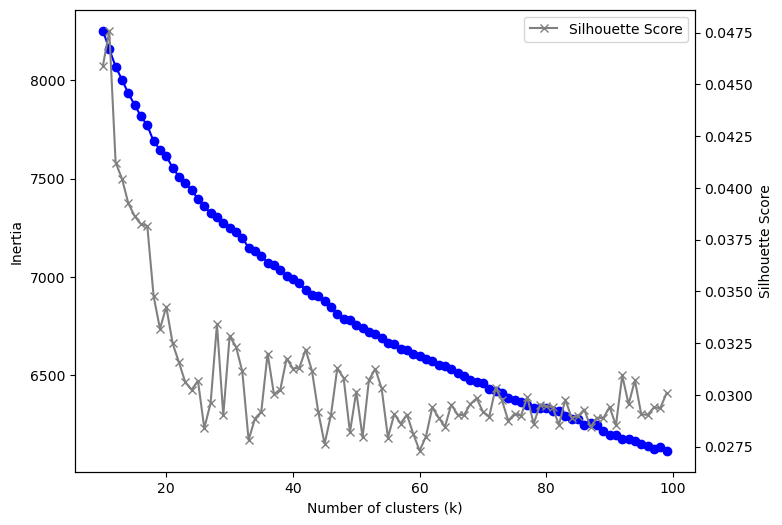

In [28]:

fig, ax  = plt.subplots(figsize=(8, 6))
ax.plot(tmp['k'], tmp['inertia'], 'o-',color='blue', label='Inertia')
# ax.vlines(elbow_point, ax.get_ylim()[0], ax.get_ylim()[1], linestyles='dashed',label='Elbow Point [Inertia]', color='red')
# ax.set_title(f'Inertia vs. Number of Clusters for {disease} [{elbow_point}]',fontdict={'fontsize': 12, 'fontweight': 'medium'})
ax.set_xlabel('Number of clusters (k)')
ax.set_ylabel('Inertia')

# Add silhouette score to the same plot
ax2 = ax.twinx()
ax2.plot(tmp['k'], tmp['silhouette_score'], 'x-', color='gray', label='Silhouette Score')
#
ax2.set_ylabel('Silhouette Score')
ax2.legend(loc='upper right')
plt.show()